## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped,PoseStamped
import tf2_ros
import sys

from utils import *
import cv2
import os


rgbd = RGBD()
scene = moveit_commander.PlanningSceneInterface()

In [40]:
%%script bash --bg
rviz -d data/task1.rviz > /dev/null 2>&1

Starting job # 3 in a separate thread.


In [13]:
##KNOWN LOCATIONS
kl_mess1= [1.04,0.3,90]
kl_table1= [1.04,1.3,90]
kl_tray=  [ -0.04168256822546347, 1.5,-90]
kl_box1=  [-0.04168256822546347, 2.427268271720426, -90]
kl_drawers=  [0.06, 0.038, -90]
### ARM 
arm_grasp_from_above=[0.19263830140116414,
 -2.2668981568652917,
 -0.007358947463759424,
 -0.9939144210462025,
 -0.17365421548386273,
 0.0]
arm_grasp_from_above_table=[0.41349380130577407,
 -1.671584191489468,
 -0.02774372779356371,
 -1.5952436225825641,
 0.22362492457833927,
 0.0]


arm_grasp_table=[0.41349380130577407,
 -1.671584191489468,
 -0.02774372779356371,
 0.0,
 0.22362492457833927,
 0.0]


arm_grasp_floor=[-1.5151551103007697e-05,
 -2.4,
 -0.2620865401925543,
 0.7019536624449207,
 0.20120924571306453,
 0.0]
arm_train_pose=[0.033749214744071214,
 -2.1204421063180217,
 -1.3982377978814715,
 -1.7296544561013807,
 2.135675364707808,
 0.0]

arm_ready_to_place=[0.03999320441056991,
 -0.4729690540086997,
 0.19361475012179108,
 -1.5269847787383313,
 -0.009753879176134461,
 0.0]

In [14]:
def segment_shelf(chan):
    image_data=rgbd.get_image()
    points_data = rgbd.get_points()

    mask=np.zeros((image_data.shape))
    plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))

    plane_mask=image_data[:,:,chan]

    ret,thresh = cv2.threshold(image_data[:,:,2],200,255,200)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=image_data[:,:,0]
    _,contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area > 20 and area < 5000 :
            print('contour',i,'area',area)

            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            print boundRect
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            xyz=[]


            for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                    xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
            xyz=np.asarray(xyz)
            cent=xyz.mean(axis=0)
            cents.append(cent)
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
            print ('cX,cY',cX,cY)
    cents=np.asarray(cents)
    plt.imshow(img )
    return (cents)

In [15]:
def segment_table2(chan):
    image_data=rgbd.get_image()
    points_data = rgbd.get_points()

    mask=np.zeros((image_data.shape))
    plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))

    plane_mask=image_data[:,:,chan]

    ret,thresh = cv2.threshold(image_data[:,:,2],240,255,200)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=image_data[:,:,0]
    _,contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area > 200 and area < 50000 :
            print('contour',i,'area',area)

            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            print boundRect
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            xyz=[]


            for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                    xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
            xyz=np.asarray(xyz)
            cent=xyz.mean(axis=0)
            cents.append(cent)
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
            print ('cX,cY',cX,cY)
    cents=np.asarray(cents)
    plt.imshow(img )
    return (cents)

In [16]:
def segment_table():
    image_data=rgbd.get_image()
    points_data = rgbd.get_points()

    mask=np.zeros((image_data.shape))
    plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))

    plane_mask=image_data[:,:,1]

    ret,thresh = cv2.threshold(image_data[:,:,2],240,255,200)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=image_data[:,:,0]
    _,contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area > 2000 and area < 50000 :
            print('contour',i,'area',area)

            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            print boundRect
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            xyz=[]


            for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                    xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
            xyz=np.asarray(xyz)
            cent=xyz.mean(axis=0)
            cents.append(cent)
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
            print ('cX,cY',cX,cY)
    cents=np.asarray(cents)
    plt.imshow(img )
    return (cents)

In [17]:
def seg_floor(image,points_data,lower=200,upper=50000):
       # image_data=rgbd.get_image()
       # points_data = rgbd.get_points()


        ##px pixels /2D world  P1 3D world
        px_y,px_x=-1,-200
        P1= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        px_y,px_x=-1,200
        P2= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        px_y,px_x=-150,320
        P3= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        #      

        V1 =P1 - P2
        V2= P3-P2
        nx,ny,nz=np.cross(V2,V1)
        print('look at the phi angle  in normal vector', np.rad2deg(cart2spher(nx,ny,nz))[2]-90)
        trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
        euler=tf.transformations.euler_from_quaternion(rot)
        print(   np.rad2deg(euler)[1],'if this degree is not the same as head tilt plane was not found')
        
        mask=np.zeros((image_data.shape))
        plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))
        mask[:,:,0]=points_data['x'] - P1[0]
        mask[:,:,1]=points_data['y'] - P1[1]
        mask[:,:,2]=points_data['z'] - P1[2]
        for i in range (image_data.shape[0]):
            for j in range (image_data.shape[1]):
                plane_mask[i,j]=-np.dot(np.asarray((nx,ny,nz,)),mask[i,j])
        plane_mask=plane_mask-np.min(plane_mask)
        plane_mask=plane_mask*256/np.max(plane_mask)
        plane_mask.astype('uint8')

        ret,thresh = cv2.threshold(plane_mask,3,255,0)

        cv2_img=plane_mask.astype('uint8')
        img=plane_mask.astype('uint8')
        _,contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        i=0
        cents=[]
        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            
            if area > lower and area < upper :
                #print('contour',i,'area',area)
                
                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,0,0), 2)
                # calculate moments for each contour
                xyz=[]
                
                
                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                M = cv2.moments(contour)
                # calculate x,y coordinate of center
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        cents=np.asarray(cents)
        plt.imshow(img)
        return cents

In [18]:
def segment_floor():
        image_data=rgbd.get_image()
        points_data = rgbd.get_points()

##### WILL PACKAGE IT BETTER SOON I PROMISE######################################################################
        ##px pixels /2D world  P1 3D world
        px_y,px_x=-1,-200
        P1= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        px_y,px_x=-1,200
        P2= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        px_y,px_x=-150,320
        P3= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
        #      

        V1 =P1 - P2
        V2= P3-P2
        nx,ny,nz=np.cross(V2,V1)
        print('look at the phi angle  in normal vector', np.rad2deg(cart2spher(nx,ny,nz))[2]-90)
        trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
        euler=tf.transformations.euler_from_quaternion(rot)
        print(   np.rad2deg(euler)[1],'if this degree is not the same as head tilt plane was not found')
        
        mask=np.zeros((image_data.shape))
        plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))
        mask[:,:,0]=points_data['x'] - P1[0]
        mask[:,:,1]=points_data['y'] - P1[1]
        mask[:,:,2]=points_data['z'] - P1[2]
        for i in range (image_data.shape[0]):
            for j in range (image_data.shape[1]):
                plane_mask[i,j]=-np.dot(np.asarray((nx,ny,nz,)),mask[i,j])
        plane_mask=plane_mask-np.min(plane_mask)
        plane_mask=plane_mask*256/np.max(plane_mask)
        plane_mask.astype('uint8')

        ret,thresh = cv2.threshold(plane_mask,3,255,0)

        cv2_img=plane_mask.astype('uint8')
        img=plane_mask.astype('uint8')
        _,contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        i=0
        cents=[]
        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            
            if area > 200 and area < 50000 :
                #print('contour',i,'area',area)
                
                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,0,0), 2)
                # calculate moments for each contour
                xyz=[]
                
                
                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                M = cv2.moments(contour)
                # calculate x,y coordinate of center
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        cents=np.asarray(cents)
        plt.imshow(img)
        return cents

In [19]:
#TF WRT HEAD SENSOR
def static_tf_publish(cents):
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan')
        else:
            broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Closest_Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            static_transformStamped.header.stamp = rospy.Time.now()
            static_transformStamped.header.frame_id = "map"
            static_transformStamped.child_frame_id = "static"+str(i)
            static_transformStamped.transform.translation.x = float(xyz_map[0])
            static_transformStamped.transform.translation.y = float(xyz_map[1])
            static_transformStamped.transform.translation.z = float(xyz_map[2])
            #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
            static_transformStamped.transform.rotation.x = 0#-quat[0]#trans.transform.rotation.x
            static_transformStamped.transform.rotation.y = 0#-quat[1]#trans.transform.rotation.y
            static_transformStamped.transform.rotation.z = 0#-quat[2]#trans.transform.rotation.z
            static_transformStamped.transform.rotation.w = 1#-quat[3]#trans.transform.rotation.w


            tf_static_broadcaster.sendTransform(static_transformStamped)
    return True


In [20]:
def cart2spher(x,y,z):
    ro= np.sqrt(x**2+y**2+z**2)
    th=np.arctan2(y,x)
    phi=np.arctan2((np.sqrt(x**2+y**2)),z)
    return np.asarray((ro,th,phi))
def spher2cart(ro,th,phi):
    x= ro * np.cos(th)* np.sin(phi)
    y= ro * np.sin(th)* np.sin(phi)
    z= ro*  np.cos(th)
    return np.asarray((x,y,z))

In [21]:

rospy.init_node("recognition")


In [22]:
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()
import moveit_commander
import moveit_msgs.msg
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-10.0, -10.0, 10.0, 10.0])

In [23]:
def seg_shelf(): 
    image= rgbd.get_h_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area > 2000 and area < 20000 :


            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this

            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            xyz=[]


            for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                    xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
            xyz=np.asarray(xyz)
            cent=xyz.mean(axis=0)
            if np.isnan(cent[0]) or np.isnan(cent[1]) or np.isnan(cent[2]):
                'nan in tf....ignoring'
                print(cent , 'rejected')
            else:
                cents.append(cent)
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
            print ('cX,cY',cX,cY)
    cents=np.asarray(cents)
    plt.imshow(im4)
    
    return(cents)


In [24]:
def add_object(name, size, pose, orientation):
    p = PoseStamped()
    p.header.frame_id = "map"       # "head_rgbd_sensor_link"
    
    p.pose.position.x = pose[0]
    p.pose.position.y = pose[1]
    p.pose.position.z = pose[2]

    p.pose.orientation.x = orientation[0] * np.pi
    p.pose.orientation.y = orientation[1] * np.pi
    p.pose.orientation.z = orientation[2] * np.pi
    p.pose.orientation.w = orientation[3] * np.pi

    scene.add_box(name, p, size)


def publish_scene():
    add_object("shelf", [1.5, 0.04, 0.4],  [2.5, 4.85, 0.78],  [0.5,0,0,0.5])
    add_object("shelf1", [1.5, 0.04, 0.4], [2.5, 4.85, 0.49], [0.5,0,0, 0.5])
    add_object("shelf2", [1.5, 0.04, 0.4], [2.5, 4.85, 0.18], [0.5,0,0, 0.5])
    add_object("shelf_wall", [1, 1, 0.04], [2.5, 4.9, 0.5], [0.5,0,0, 0.5])
    add_object("shelf_wall1", [.04, 1, 0.4], [2.7, 4.9, 0.5],[0.5,0,0, 0.5])
    add_object("shelf_wall2", [.04, 1, 0.4], [1.8, 4.9, 0.5], [0.5,0,0 ,0.5])    
    add_object("table_big", [1.7, 0.13, 0.7], [0.95, 1.9, 0.34],  [0.5,0,0, 0.5])
    add_object("table_big_legs1",[.01,.6,.2], [1.55,1.6,0.1],       [0.5,0,0, 0.5])
    add_object("table_big_legs2",[.01,.6,.2], [0.45,1.6,0.1],       [0.5,0,0 ,0.5])
    add_object("table_small", [0.7, 0.01, 0.4], [0.1, 1.85, 0.61],  [0.5,0,0 ,0.5])
    add_object("table_small_legs1",[.01,.6,.2], [-0.2,1.7,0.3],      [0.5,0,0, 0.5])
    add_object("table_small_legs2",[.01,.6,.2], [0.18,1.7,0.3], [0.5,0,0 ,0.5])
    add_object("table_tray", [0.65, 0.01, 0.7], [1.8, -0.65, 0.4], [0.5,0,0, 0.5])
    add_object("big_wall" , [6.0, 0.2, 0.2], [3.2,  2.0, 0.0],  [0,0.0,0.5 ,0.5])
    add_object("mid_wall" , [4.0, 0.2, 0.2], [0.1,  2.1, 0.0],  [0,0.0,0.0 ,1/np.pi])##COME ON.....
    add_object("door_wall" , [5.0, 0.2, 0.2], [-0.8, 2.8, 0.0],  [0,0.0,0.5 ,0.5     ])
    add_object("close_wall", [4.0, 0.2, 0.2], [1.1, -0.5, 0.0],  [0,0.0,0.0 ,1/np.pi])##COME ON.....
    add_object("far_wall",   [4.0, 0.2, 0.2], [1.1, 5.0, 0.0],  [0,0.0,0.0 ,1/np.pi])##COME ON.....
    

    return True

rvizを起動します．ロボットモデル、カメラ映像、ポイントクラウドが表示されています。

In [36]:
def cents_to_sceneobjs(cents):
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan','error')
            return False
        else:
            broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Closest_Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)


            p = PoseStamped()
            p.header.frame_id = "map"       # "head_rgbd_sensor_link"
            p.pose.position.x = xyz_map[0]
            p.pose.position.y = xyz_map[1]
            p.pose.position.z = xyz_map[2]
            p.pose.orientation.x = 0.5 * np.pi
            p.pose.orientation.w = 0.5 * np.pi
            scene.add_box('obs'+str(i),p,(.1,.1,.1) )
    return True
        



In [25]:
scene_pub = rospy.Publisher('planning_scene',
                                         moveit_msgs.msg.PlanningScene,
                                         queue_size=5)

In [26]:
publish_scene()
#scene.remove_world_object()

True

In [27]:
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from geometry_msgs.msg import PoseStamped, Point , Quaternion
from actionlib_msgs.msg import GoalStatus

In [28]:
wb=whole_body.get_current_joint_values()


In [29]:
image_data=rgbd.get_image()
points_data = rgbd.get_points()

('look at the phi angle  in normal vector', -26.314947661794193)
(-0.07520620639232102, 'if this degree is not the same as head tilt plane was not found')


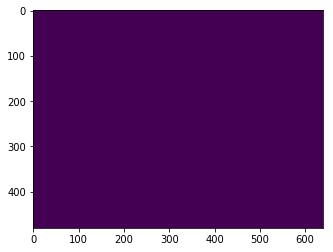

In [30]:

cents=seg_floor(image_data,points_data,2,5000)

In [31]:
wb

[-0.0030580256525098606,
 0.0020613392457285683,
 -0.027377604555499417,
 0.04997714073874884,
 -0.00027142661012025115,
 -1.5700200694085944,
 -1.572876392199019,
 0.0005242230577851004,
 0.0]

In [32]:
publish_scene()

True

In [33]:
"""pose_tray_1

frame_id: "odom"
pose: 
  position: 
    x: 2.07474262655
    y: -0.463993086819
    z: 0.470428742931
  orientation: 
    x: 0.787825948964
    y: -0.583793844356
    z: 0.156526059701
    w: 0.118383335252"""
whole_body.get_active_joints()

['odom_y',
 'odom_x',
 'odom_r',
 'arm_lift_joint',
 'arm_flex_joint',
 'arm_roll_joint',
 'wrist_flex_joint',
 'wrist_roll_joint',
 'wrist_ft_sensor_frame_joint']

<a id='start'></a>

In [34]:

 
#goal_x , goal_y,goal_yaw= kl_drawers
#scene.remove_world_object()
#Takeshi neutral
move_hand(0)
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()
move_base_goal(2.5,1,90)
scene.remove_world_object()

('look at the phi angle  in normal vector', -45.05681201283638)
(45.10411608117664, 'if this degree is not the same as head tilt plane was not found')
[[-0.73422194 -0.09774987  1.3643669 ]]


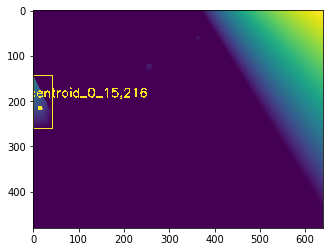

In [35]:
wb=whole_body.get_current_joint_values()
#wb[3]+=0.6
#whole_body.go(wb)
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

head.go(head_val)

trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))

euler=tf.transformations.euler_from_quaternion(rot)

trans, euler

#cents=segment_shelf(2)
cents=segment_floor()
#arm.go(arm_grasp_floor)
print cents

In [37]:
publish_scene()

True

('look at the phi angle  in normal vector', -45.110059352344024)
(45.11232803212787, 'if this degree is not the same as head tilt plane was not found')


True

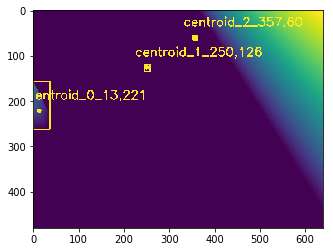

In [38]:
#deprecate segmentation_floor in favor of seg_floor()
cents=seg_floor(rgbd.get_image(),rgbd.get_points(),2,5000)
if len (cents!=0):
    static_tf_publish(cents)
cents_to_sceneobjs(cents)

In [39]:
for i in range(5):
    move_hand(0)
    arm.set_named_target('go')
    arm.go()
    head.set_named_target('neutral')
    head.go()
    wb=whole_body.get_current_joint_values()
    wb[0]=3.7
    wb[1]=2.5
    wb[2]=np.pi
    wb[3]+=0.5
    print i
    wb[4:]=arm_grasp_table[1:]
    succ=whole_body.go(wb)
    if succ: 
        break

0
1
2


KeyboardInterrupt: 

In [ ]:
#move_base_goal(2.3,4,180)


In [ ]:
#move_base_goal(goal_x,goal_y,goal_yaw)
#move_base_goal(2.2,4.0,goal_yaw)
#arm.go(arm_grasp_floor)
publish_scene()
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(-90)
head_val[1]=np.deg2rad(-30)

head.go(head_val)

trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))

euler=tf.transformations.euler_from_quaternion(rot)

trans, euler
cents=seg_shelf()



In [ ]:
#cents=segment_shelf(2)



if len (cents!=0):
    static_tf_publish(cents)

    

In [ ]:
wb=whole_body.get_current_joint_values()
wb[0]+=0.2
whole_body.go(wb)
cents=seg_shelf()

In [ ]:
static_tf_publish(cents)

In [ ]:
head.set_named_target('neutral')
head.go()
arm.set_named_target('neutral')
arm.go()

In [ ]:
from utils_takeshi import *

In [ ]:

image= rgbd.get_h_image()
points_data= rgbd.get_points()
values=image.reshape((-1,3))
values= np.float32(values)
criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
k=6
_ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
cc=np.uint8(cc)
segmented_image= cc[labels.flatten()]
segmented_image=segmented_image.reshape(image.shape)
th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
kernel = np.ones((5,5),np.uint8)
im4=cv2.erode(th3,kernel,iterations=4)
plane_mask=points_data['z']
cv2_img=plane_mask.astype('uint8')
img=im4
_,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
i=0
cents=[]
bbs=[]
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)

    if area > 2000 and area < 20000 :


        boundRect = cv2.boundingRect(contour)
        bbs.append(boundRect)
        #just for drawing rect, dont waste too much time on this

        img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
        # calculate moments for each contour
        xyz=[]


        for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
            for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                aux=np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy]))
                if not (np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2])):
                    
                
                    xyz.append(aux)
        xyz=np.asarray(xyz)

In [ ]:
xyz[666]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca= PCA(n_components=3).fit(xyz)

In [ ]:
pca.components_

In [ ]:

trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))

euler=tf.transformations.euler_from_quaternion(rot)
cents=seg_shelf()
cents

In [ ]:
static_tf_publish(cents)

In [ ]:
cents

In [ ]:
def seg_shelf(): 
    image= rgbd.get_h_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area > 2000 and area < 20000 :


            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this

            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            xyz=[]


            for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                    xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
            xyz=np.asarray(xyz)
            cent=xyz.mean(axis=0)
            if np.isnan(cent[0]) or np.isnan(cent[1]) or np.isnan(cent[2]):
                'nan in tf....ignoring'
                print(cent , 'rejected')
            else:
                cents.append(cent)
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
            cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
            print ('cX,cY',cX,cY)
    cents=np.asarray(cents)
    plt.imshow(im4)
    
    return(cents)
